Created by Alberto Ueda on 2017-01-25

## Loading Libs and Data

In [2]:
N_AUTHORS = None

%pylab inline

import sys
sys.path.append('../../../../../ufmg-latin/pscore/rfs/')

import rfslib.rankmodels
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import rfslib.datasets
dataset = rfslib.datasets.DBLPDataset('../../../../../pscore/datasets/',nauthors=N_AUTHORS)
dataset.prepare()
venuerank  = dataset.dfvenues.copy()
authorrank = dataset.dfauthors.copy()
grouprank  = dataset.dfgroups.copy()

Populating the interactive namespace from numpy and matplotlib
(1595771, 1) authors
(1595771, 1) authors loaded


In [3]:
import rfslib.pscorefactory
pscore = rfslib.pscorefactory.PScoreRankFactory(dataset,cpp=True,ranksize=100,fullrank=False)

## Filtering Venues

In [28]:
# %%time
vap = dataset.dfvenuesauthorpaper.copy()

def live_venues_in(year):
    return vap[vap.Year >= year].drop_duplicates('Vkey').Vkey.tolist()

def dead_venues_in(year):
    live = live_venues_in(year)
    dead = vap[~vap.Vkey.isin(live)].drop_duplicates('Vkey').Vkey.tolist()
    return dead

def venues_with_min_psize(min_papers):
    count = vap.drop_duplicates('PID').groupby('Vkey').PID.count()
    return count[count > min_papers].index.tolist()

def valid_vkeys(year, min_papers):
    big = set(venues_with_min_psize(min_papers))
    dead = set(dead_venues_in(year))
    
    return big.difference(dead)
    
valid_vkeys(2014, 10000)

{'conf/chi',
 'conf/globecom',
 'conf/hci',
 'conf/hicss',
 'conf/icassp',
 'conf/icc',
 'conf/icip',
 'conf/icra',
 'conf/igarss',
 'conf/interspeech',
 'conf/iros',
 'conf/iscas',
 'conf/vtc',
 'journals/amc',
 'journals/bioinformatics',
 'journals/cacm',
 'journals/corr',
 'journals/dm',
 'journals/ieicet',
 'journals/tcs',
 'journals/tit',
 'journals/tsp'}

In [13]:
%%time
valid_venues = valid_vkeys(year=2012, min_papers=100)
print len(valid_venues)

2690
CPU times: user 2.91 s, sys: 223 ms, total: 3.13 s
Wall time: 3.13 s


In [5]:
venuerank  = dataset.dfvenues.copy()
#venuerank = venuerank[venuerank.Vkey.isin(valid_venues)]
venuerank.head()

,Vkey,VPsize,VPyear
0,journals/corr,NaN,NaN
1,conf/ssp,361.0,2012.0
2,conf/isit,4224.0,2008.0
3,journals/tcom,7959.0,1989.0
4,journals/twc,5728.0,2002.0


## Venues' Qualis, h-index and citations

In [6]:
import venue.qualis
from venue.qualis import qualis

venuerank['Qualis'] = venuerank.Vkey.map(lambda vkey: qualis.get_qualis_dblp('dblp:'+vkey))
venuerank['QualisRel'] = pd.Series()
venuerank['QualisRel'] = venuerank['Qualis'].replace(
    {'A1':7,'A2':6,'B1':5,'B2':4,'B3':3,'B4':2,'B5':1,'C ':0,np.nan:0})
print venuerank['QualisRel'].unique()

dfgsvenues = pd.read_csv('../data/dblp-gs-venues.csv',index_col=0)
dfgsvenues.rename(columns={'GSHindex':'H-Index'},inplace=True)
if 'H-Index' in venuerank.columns:
    del venuerank['H-Index']
venuerank = venuerank.reset_index().set_index('Vkey').join(dfgsvenues['H-Index']).reset_index().set_index('index')

vkey_cits = pd.read_csv('../data/vkey_cits.csv',index_col=0,names=['Vkey','Vcits']) # TODO by year
venuerank = venuerank.reset_index().set_index('Vkey')
venuerank['Citations'] = vkey_cits['Vcits']
venuerank = venuerank.reset_index().set_index('index')

venuerank.sort_values(by='H-Index',ascending=False).head()

[ 0.  5.  7.  6.  3.  4.  2.  1.]


,Vkey,VPsize,VPyear,Qualis,QualisRel,H-Index,Citations
index,,,,,,,
5763,journals/nature,1.0,2007.0,None,0.0,355.0,NaN
5718,journals/science,1.0,1983.0,None,0.0,311.0,2481.0
587,journals/nar,5753.0,1975.0,B1,5.0,164.0,803995.0
4714,conf/and,32.0,2009.0,None,0.0,162.0,142.0
5246,conf/sci,28.0,1999.0,None,0.0,136.0,84.0


In [7]:
# Returns 3 rankings: venues, authors and groups
# Calculate the rankings based on previous rankings, 
def run_pscore(params,venuerank,authorrank,grouprank,field):
    
    dranks = pscore.rank(params)
    vrank,arank,grank = dranks['venues'],dranks['authors'],dranks['groups']
    vscore,ascore,gscore = vrank['Score'],arank['Score'],grank['Score']

    # add new score to dfrank with the name 'field' 
    rfslib.rankmodels.addscore(venuerank, vscore,field)
    rfslib.rankmodels.addscore(authorrank,ascore,field)
    rfslib.rankmodels.addscore(grouprank, gscore,field)
    
    return vrank,arank,grank

def head_ranks(n=5): 
    print vrank.sort_values(by='Score',ascending=False).head(n), '\n\n', 
    print arank.sort_values(by='Score',ascending=False).head(n), '\n\n', 
    print grank.sort_values(by='Score',ascending=False).head(n)

## Seeds: Top Venues of a single CS Sub-area

In [47]:
subarea_seeds = {
    'Algorithm':['conf/soda', 'journals/algorithmica'],
    'Artificial intelligence':['conf/ijcai', 'journals/ai'],
    'Bioinformatics':['conf/bibm', 'journals/bioinformatics'],
    'Cognitive science':['conf/IEEEicci', 'journals/cogsci'],
    'Computational biology':['conf/recomb', 'journals/ploscb'],
    'Computational science':['conf/iccS', 'journals/siamsc'],
    'Computer architecture':['conf/isca', 'journals/tcad'],
    'Computer graphics (images)':['conf/siggraph', 'journals/tvcg'],
    'Computer hardware':['conf/iccad', 'journals/tcad'],
    'Computer network':['conf/infocom', 'journals/ton'],
    'Computer security':['conf/ccs', 'journals/tissec'],
    'Computer vision':['conf/cvpr', 'journals/ijcv'],
    'Data mining':['conf/kdd', 'journals/sigkdd'],
    'Data science':['conf/kdd', 'journals/tkdd'],
    'Database':['conf/sigmod', 'journals/tods'],
    'Distributed computing':['conf/icdcs', 'journals/tpds'],
    'Embedded system':['conf/sensys', 'journals/tecs'],
    'Human-computer interaction':['conf/chi', 'journals/tochi'],
    'Information retrieval':['conf/sigir', 'journals/tois'],
    'Internet privacy':['conf/sp', 'journals/ijisp'],
    'Knowledge management':['conf/cikm', 'journals/jkm'],
    'Machine learning':['conf/icml', 'journals/jmlr'],
    'Management science':['conf/ifip8-3', 'journals/mansci'],
    'Mathematical optimization':['conf/ipco', 'journals/ior'],
    'Multimedia':['conf/mm', 'journals/tmm'],
    'Natural language processing':['conf/emnlp', 'journals/coling'],
    'Operating system':['conf/sosp', 'journals/sigops'],
    'Operations research':['conf/or', 'journals/eor'],
    'Parallel computing':['conf/ipps', 'journals/tpds'],
    'Pattern recognition':['conf/cvpr', 'journals/pr'],
    'Programming language':['conf/pldi', 'journals/toplas'],
    'Real-time computing':['conf/rtss', 'journals/rts'],
    'Simulation':['conf/wsc', 'journals/simpra'],
    'Speech recognition':['conf/interspeech', 'journals/taslp'],
    'Telecommunications':['conf/sigcomm', 'journals/tcom'],
    'Theoretical computer science':['conf/stoc', 'journals/siamcomp'],
    'World Wide Web':['conf/www', 'journals/ws'],
}

# Testing Vkeys
keys_for_test = [vkey for sublist in subarea_seeds.values() for vkey in sublist]
dead_venues = dead_venues_in(2010)
big_venues = venues_with_min_psize(100)

for vkey in keys_for_test:
    if (vkey not in dataset.dfvenues.Vkey.values):
        print 'Venue not found:', vkey         
        
    elif (vkey in dead_venues):
        print 'Dead venue:', vkey     
        
    elif (vkey not in big_venues):
        print 'Venue without a min of papers:', vkey            
        

In [12]:
# %%time
vap = dataset.dfvenuesauthorpaper.copy()

def live_venues_in(year):
    return vap[vap.Year >= year].drop_duplicates('Vkey').Vkey.tolist()

def dead_venues_in(year):
    live = live_venues_in(year)
    dead = vap[~vap.Vkey.isin(live)].drop_duplicates('Vkey').Vkey.tolist()
    return dead

def venues_with_min_psize(min_papers):
    count = vap.drop_duplicates('PID').groupby('Vkey').PID.count()
    return count[count > min_papers].index.tolist()

def valid_vkeys(year, min_papers):
    big = set(venues_with_min_psize(min_papers))
    dead = set(dead_venues_in(year))
    
    return big.difference(dead)
    

    valid_vkeys(2014, 10000)

{'conf/chi',
 'conf/globecom',
 'conf/hci',
 'conf/hicss',
 'conf/icassp',
 'conf/icc',
 'conf/icip',
 'conf/icra',
 'conf/igarss',
 'conf/interspeech',
 'conf/iros',
 'conf/iscas',
 'conf/vtc',
 'journals/amc',
 'journals/bioinformatics',
 'journals/cacm',
 'journals/corr',
 'journals/dm',
 'journals/ieicet',
 'journals/tcs',
 'journals/tit',
 'journals/tsp'}

## Main methods

In [63]:
# Run pscore on subarea using the seeds. Returns a ranking of venues
def rank_subarea(subarea, output_dir, seeds, n=0, only_valid_venues=False, only_selected_venues=None):
    refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in seeds ]
    params = dict(area=1,model='P-score',year=(1940,2015),refvenues=refvenues,top_authors=200)

    run_pscore(params, venuerank, authorrank, grouprank, subarea)
       
    # Filter venues after Pscore computation
    if (only_selected_venues != None):
        filtered_venues = venuerank[venuerank.Vkey.isin(only_selected_venues)]
        rankings = concat_rankings(subarea, filtered_venues, n, only_valid_venues)
    else:
        rankings = concat_rankings(subarea, venuerank, n, only_valid_venues)
        
    rankings.to_csv('output/subareas_rankings/' + output_dir + '/' + subarea + '.csv')    
    
    return rankings

In [44]:
# Rank the venues using two different features and concatenate the rankings side-by-side
def concat_rankings(subarea, venuerank, n, only_valid_venues=False):

    pscorerank = venuerank[['Vkey', 'VPsize', 'Citations', 'Qualis', 'H-Index', subarea]
                          ].sort_values(by=subarea, ascending=False)

    # Filtering Venues by recency and min-publications
    if (only_valid_venues):
        pscorerank = pscorerank[pscorerank.Vkey.isin(valid_venues)]
    
    # e.g. how many venues we know the correct subareas
    pscorerank = pscorerank.head(n)
    
    # P-score ranking (2nd to appear)
    pscorerank.index = range(1, pscorerank.shape[0] + 1)
    pscorerank['Rank'] = pscorerank.index
    pscorerank.rename(columns={subarea:'P-score'}, inplace=True)
    pscorerank[''] = ""
    emptycol = pscorerank['']

    # H-index ranking (same venues ranked by previous P-score) (1st to appear)
    hindexrank = pscorerank.sort_values(by='H-Index', ascending=False)
    hindexrank['Rank'] = range(1, hindexrank.shape[0] + 1)
    hindexrank.set_index('Rank', inplace=True)
    hindexrank.rename(columns={'P-score':'P-score_'}, inplace=True)
    pscorerank = pscorerank[['Rank', 'Vkey', 'Qualis', 'P-score']]
    all_rankings = pd.concat([hindexrank, pscorerank], axis=1)

    # 3rd raking: P-score / N. Publications 
    psvpranking = hindexrank
    psvpranking['PS/VP'] = psvpranking['P-score_'] / psvpranking['VPsize']
    psvpranking = psvpranking.sort_values(by='PS/VP', ascending=False)
    psvpranking.index = range(1, psvpranking.shape[0] + 1)
    psvpranking['Rank'] = psvpranking.index
    psvpranking = psvpranking[['Rank', 'Vkey', 'Qualis', 'PS/VP']]
    all_rankings = pd.concat([all_rankings, emptycol, psvpranking], axis=1)
    del all_rankings['P-score_']
    
    return all_rankings

## Rank!

In [104]:
# TODO Updating for each one for now
n = 50
selected_venues = None
selected_venues = pd.read_csv('expert-subareas-classification/dm/venues_subareas-2-votes.csv', nrows=n)['Vkey'].tolist()


In [105]:
%%time

subarea_seeds = {
    #'Computer network':['conf/infocom', 'journals/ton'],
    'Data mining':['conf/kdd', 'journals/sigkdd'],
    #'Database':['conf/sigmod', 'journals/tods'],
    #'Knowledge management':['conf/cikm', 'journals/jkm'],
    #'Information retrieval':['conf/sigir', 'journals/tois'],
}

# VERY IMPORTANT SETTING 
rankingsize = 50

print 'Subareas ranked successfully: '

for subarea, seeds in subarea_seeds.items():
    last = rank_subarea(subarea, 'march-9-the-right-50', seeds, rankingsize, True, selected_venues)
    print subarea + ',',

print '\n\n', last.head()


Subareas ranked successfully: 
Data mining, 

             Vkey  VPsize  Citations Qualis  H-Index    Rank       Vkey  \
Rank                                                                      
1        conf/www  4501.0   120253.0     A1     83.0       1   conf/kdd   
2     journals/ml  1309.0   184440.0     A1     73.0       2  conf/icdm   
3       conf/icml  3294.0   290468.0     A1     69.0       3  conf/cikm   
4       conf/nips  5684.0   404822.0     A1     66.0       4  conf/icde   
5     conf/sigmod  3706.0   337960.0     A1     61.0       5  conf/icml   

     Qualis  P-score    Rank               Vkey Qualis     PS/VP  
Rank                                                              
1        A1   1423.0       1      journals/tkdd   None  0.545946  
2        A1    935.0       2    journals/sigkdd   None  0.524946  
3        A1    602.0       3           conf/kdd     A1  0.495992  
4        A1    521.0       4           conf/sdm     A2  0.468809  
5        A1    499.0      

In [49]:
last.head(5)

,Vkey,VPsize,Citations,Qualis,H-Index,,Rank,Vkey,Qualis,P-score,,Rank,Vkey,Qualis,PS/VP
Rank,,,,,,,,,,,,,,,
1,journals/cm,1467.0,7672.0,A1,86.0,,1,journals/tcom,A1,3154.0,,1,conf/hotnets,B3,0.479381
2,journals/sigpro,4742.0,50775.0,A1,84.0,,2,conf/icc,A2,2198.0,,2,journals/tcom,A1,0.396281
3,conf/infocom,6943.0,350398.0,A1,76.0,,3,conf/globecom,A1,2098.0,,3,conf/nsdi,A1,0.326403
4,conf/nsdi,481.0,17531.0,A1,54.0,,4,journals/twc,A1,1794.0,,4,journals/twc,A1,0.313198
5,conf/isit,4224.0,15815.0,B1,49.0,,5,journals/tit,A1,1358.0,,5,conf/sigcomm,A1,0.259903


## Other stuff

In [34]:
venuerank[venuerank.index==247]
# venuerank[venuerank.Algorithm.notnull()].shape[0]
# venuerank.sort_values(by='Information retrieval',ascending=False)
# venuerank = venuerank.ix[:,0:-1]
# venuerank.to_csv('output/All Rankings of Venues (using as seed the MS TOP1 conf and journal).csv')

,Vkey,VPsize,VPyear,Qualis,QualisRel,H-Index,Citations,Computer vision,XXX,Information retrieval,Computer network,Database,Knowledge management,Data mining
index,,,,,,,,,,,,,,
247,conf/sigir,3545.0,1971.0,A1,7.0,49.0,205477.0,NaN,NaN,1895.0,NaN,89.0,1223.0,248.0


In [12]:
vap = dataset.dfvenuesauthorpaper.copy()

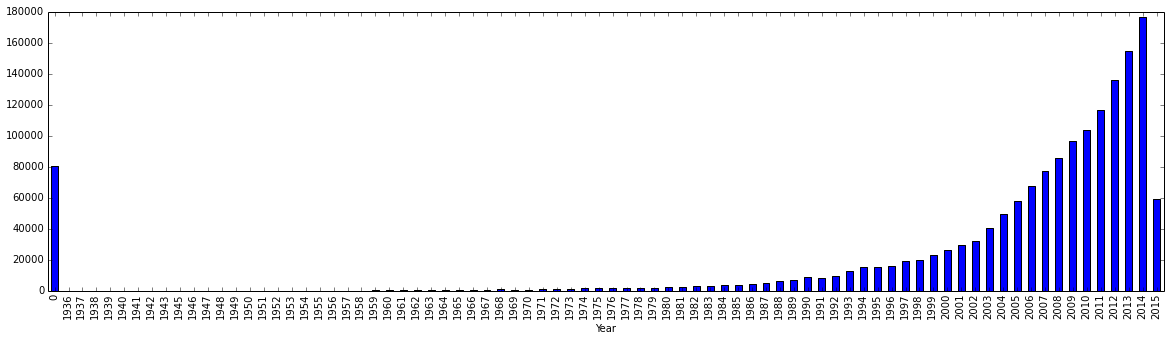

In [13]:
papers_by_year = vap.drop_duplicates('AID').groupby('Year').AID.count()
papers_by_year.plot(kind='bar', figsize=(20,5))

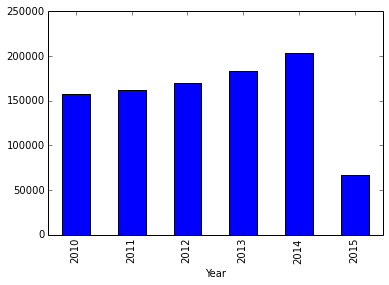

In [22]:
# TODO store last publication on dataset
vap[vap.Year >= 2010].drop_duplicates('AID').groupby('Year').AID.count().plot(kind='bar')

In [203]:
seeds = ['conf/sigir', 'journals/tois']

refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in seeds ]
params = dict(area=1,model='P-score',year=(1940,2015),refvenues=refvenues,top_authors=200)

run_pscore(params, venuerank, authorrank, grouprank, 'SIGIR+TOIS')
    
#grouprank[['Name', 'SIGIR+TOIS']]
venuerank

# TODO Why NaN ?

,Vkey,VPsize,VPyear,SIGIR+TOIS
0,journals/corr,NaN,NaN,NaN
1,conf/ssp,361.0,2012.0,NaN
2,conf/isit,4224.0,2008.0,NaN
3,journals/tcom,7959.0,1989.0,NaN
4,journals/twc,5728.0,2002.0,NaN
5,journals/jstsp,733.0,2008.0,NaN
6,conf/acssc,1721.0,2011.0,NaN
7,journals/tmc,1549.0,2002.0,NaN
8,journals/tit,13667.0,1953.0,NaN
9,journals/wc,1264.0,1994.0,NaN
